In [ ]:
import numpy as np
import scipy.stats
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

# Goal: Presymptomatic to Mild Symptoms duration Distribution

Let's determine the best priors for the presymptomatic to mild duration distribution 

Let's translate covidestim's prior distribution over durations, which has a foundation in the Gamma distribution, into our new, more flexible distribution family.


### Reviewing the best evidence from the literature

If we look at the Covid Estim study (Chitwood et al, July 2021), we can find the following on page 19

<https://www.medrxiv.org/content/10.1101/2020.06.17.20133983v3.full.pdf#page=19>


<img src="table1_prior_spec_top.png" width="60%"/>
...
<img src="table1_prior_spec_bottom.png" width="60%"/>


Let's look in particular at reference #37:

> 37. SA Lauer, KH Grantz, Q Bi, et al. “The Incubation Period of Coronavirus Disease 2019 534 
(COVID-19) From Publicly Reported Confirmed Cases: Estimation and Application.” Annals 535 
of Internal Medicine (2020). 172(9), 577--582. ISSN 0003-4819, 1539-3704, doi: 10.7326/M20-0504

<https://www.acpjournals.org/doi/full/10.7326/M20-0504>

This is a study about confirmed COVID-19 cases reported between **4 January 2020 and 24 February 2020**

The study suggests that:

> The median incubation period was estimated to be 5.1 days (95% CI, 4.5 to 5.8 days), and 97.5% of those who develop symptoms will do so within 11.5 days (CI, 8.2 to 15.6 days) of infection. These estimates imply that, under con- servative assumptions, 101 out of every 10 000 cases (99th percentile, 482) will develop symptoms after 14 days of active monitoring or quarantine

We'll assume for a moment that these numbers are our best available knowledge (naturally, we probably want to find a better study from 2021).

So, we're looking for a prior distribution that meets the following criteria:

* 50th percentile of ~5 days
* 97.5th percentile of 11-12 days
* 99th percentile of 14 days

### Generic function to assess how well samples from a proposed distribution fit our criteria

In [116]:
def pprint_samples(samps_v1_S, samps_v2_S):
    pd.set_option('display.precision', 3)
    row_dict_list = list()
    for perc, desired in [(1.0, np.nan), (2.5, np.nan), (50, 5.1), (97.5, 11.5), (99.0, 14.0)]:
        observed1 = np.percentile(samps_v1_S, perc)
        observed2 = np.percentile(samps_v2_S, perc)
        row_dict_list.append(dict(perc=perc, desired=desired, observed1=observed1, observed2=observed2))
    df = pd.DataFrame(row_dict_list)
    print(df)

## Does the chosen Gamma(3.41, 0.61) distribution from Covid Estim meet these criteria?

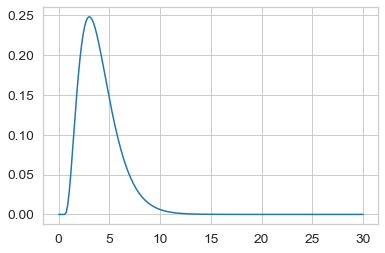

In [117]:
alpha = 3.41
beta = 0.61

candidate_val_G = np.linspace(1e-6, 30, 201)

pdf_G = scipy.stats.gamma(alpha, beta).pdf(candidate_val_G)

plt.plot(candidate_val_G, pdf_G, '-', label='GamPDF');

In [118]:
# Draw many samples
S = 1000000
gamma_samps_v1_S = scipy.stats.gamma(alpha, beta).rvs(size=S, random_state=101)
gamma_samps_v2_S = scipy.stats.gamma(alpha, beta).rvs(size=S, random_state=202)

In [119]:
pprint_samples(gamma_samps_v1_S, gamma_samps_v2_S)

   perc  desired  observed1  observed2
0   1.0      NaN      1.190      1.196
1   2.5      NaN      1.409      1.414
2  50.0      5.1      3.690      3.694
3  97.5     11.5      8.470      8.461
4  99.0     14.0      9.704      9.675


In [120]:
import autograd.numpy as ag_np
import autograd.scipy.stats as ag_stats

## Let's find the best 1-parameter duration distribution that fits our constraints

In [121]:
def calc_1param_loss(lam, J=20, day_p50=5, day_p97=11, day_p99=14):
    logpmf_J = ag_stats.poisson.logpmf(np.arange(1, J), lam)
    pmf_J = ag_np.exp(logpmf_J)
    denom = ag_np.sum(pmf_J)
    pmf_J = pmf_J / denom
    cdf_J = ag_np.cumsum(pmf_J)
    
    error_at_p50 = 0.5 * np.square(0.5 - cdf_J[day_p50-1])
    error_at_p97 = 0.35 * np.square(0.975 - cdf_J[day_p97-1])
    error_at_p99 = 0.15 * np.square(0.99 - cdf_J[day_p99-1])
    
    return error_at_p50 + error_at_p97 + error_at_p99

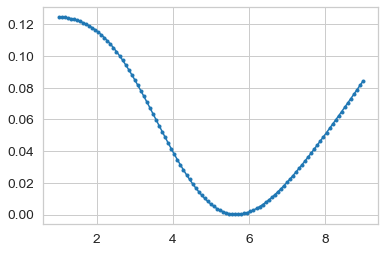

In [122]:
lam_G = np.linspace(1, 9, 101);
cost_G = np.asarray([calc_1param_loss(lam_G[gg]) for gg in range(lam_G.size)]);
plt.plot(lam_G, cost_G, '.-');

In [123]:
bestid = np.argmin(cost_G)
bestlam = lam_G[bestid]

In [124]:
def sample_from_1param(lam, size=100000, J=20, random_state=0):
    logpmf_J = ag_stats.poisson.logpmf(np.arange(1, J), lam)
    pmf_J = ag_np.exp(logpmf_J)
    denom = ag_np.sum(pmf_J)
    pmf_J = pmf_J / denom

    prng = np.random.RandomState(random_state)
    return prng.choice(np.arange(1, J), p=pmf_J, size=size)

In [125]:
samps_v1_S = sample_from_1param(bestlam, size=S, random_state=1)
samps_v2_S = sample_from_1param(bestlam, size=S, random_state=2)

In [126]:
print("1 param COST: %.7f" % (cost_G[bestid]))

1 param COST: 0.0000673


In [127]:
pprint_samples(samps_v1_S, samps_v2_S)

   perc  desired  observed1  observed2
0   1.0      NaN        1.0        1.0
1   2.5      NaN        2.0        2.0
2  50.0      5.1        5.0        5.0
3  97.5     11.5       11.0       11.0
4  99.0     14.0       12.0       12.0


## 2-parameter flexible model

We can draw $\Delta_i$ as follows:

\begin{align}
\Delta_i \sim \text{Cat}( \pi_1, \pi_2, \ldots \pi_J &)
\\
\qquad [\pi_1, \ldots \pi_j \ldots \pi_J] &\gets \text{softmax}( [\ell_1, \ell_2, \ldots \ell_J] )
\\
\qquad \ell_j &= \frac{\log \text{PoiPMF}(j | \lambda)}{\nu}
\end{align}

Goal: Given a specific Gamma defined by $\alpha, \beta$, find the $\lambda, \nu$ values that match it...

## Let's find the best 2-parameter duration distribution that fits our constraints

In [128]:
def calc_2param_loss(lam, nu, J=20, day_p50=5, day_p97=11, day_p99=14):
    logpmf_J = ag_stats.poisson.logpmf(np.arange(1, J), lam) / nu
    pmf_J = ag_np.exp(logpmf_J)
    denom = ag_np.sum(pmf_J)
    pmf_J = pmf_J / denom
    cdf_J = ag_np.cumsum(pmf_J)
    
    error_at_p50 = 0.5 * np.square(0.5 - cdf_J[day_p50-1])
    error_at_p97 = 0.35 * np.square(0.975 - cdf_J[day_p97-1])
    error_at_p99 = 0.15 * np.square(0.99 - cdf_J[day_p99-1])
    
    return error_at_p50 + error_at_p97 + error_at_p99

In [129]:
G = 101
H = 99
lam_G = np.linspace(1, 9, G);
nu_H = np.logspace( np.log10(0.05), np.log10(50), H);

nu_GH, lam_GH = np.meshgrid(nu_H, lam_G);
assert nu_GH.shape == (G,H)

In [130]:
cost_GH = np.zeros((G,H))
for gg in range(G):
    for hh in range(H):
        cost_GH[gg,hh] = calc_2param_loss(lam_GH[gg,hh], nu_GH[gg,hh]);

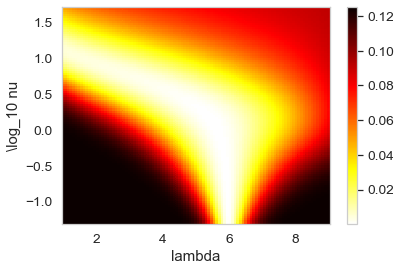

In [131]:
plt.pcolor(lam_GH, np.log10(nu_GH), cost_GH, shading='nearest', cmap='hot_r');
plt.colorbar();
plt.xlabel('lambda');
plt.ylabel('\log_10 nu');

In [132]:
minrow, mincol = np.unravel_index(np.argmin(cost_GH, axis=None), cost_GH.shape)

In [133]:
cost_GH[minrow, mincol]

1.0931276716137613e-05

In [134]:
bestlam = lam_GH[minrow, mincol]
bestnu = nu_GH[minrow, mincol]

In [135]:
bestlam, bestnu

(5.5600000000000005, 1.2797739613497678)

### Check what the distribution achieves

In [164]:
def sample_from_2param(lam, nu, size=100000, J=20, random_state=0):
    logpmf_J = ag_stats.poisson.logpmf(np.arange(1, J), lam) / nu
    pmf_J = ag_np.exp(logpmf_J)
    denom = ag_np.sum(pmf_J)
    pmf_J = pmf_J / denom

    if isinstance(random_state, int):
        prng = np.random.RandomState(random_state)
    else:
        prng = random_state
    return prng.choice(np.arange(1, J), p=pmf_J, size=size)

In [137]:
samps_2param_v1_S = sample_from_2param(bestlam, bestnu, size=S, random_state=1)
samps_2param_v2_S = sample_from_2param(bestlam, bestnu, size=S, random_state=2)

In [138]:
print("2 param COST: %.7f" % (cost_GH[minrow, mincol]))

2 param COST: 0.0000109


In [139]:
pprint_samples(samps_2param_v1_S, samps_2param_v2_S)

   perc  desired  observed1  observed2
0   1.0      NaN        1.0        1.0
1   2.5      NaN        1.0        1.0
2  50.0      5.1        6.0        6.0
3  97.5     11.5       11.0       11.0
4  99.0     14.0       13.0       13.0


# Now we need a PRIOR on lambda and nu, not just a point estimate


Prior beliefs about lambda: 

* We'll use a TRUNCATED NORMAL distribution
* Let's set the MEAN of this prior to the best lambda value found here: 5.5600
* Let's set the STDDEV of this prior to 1, so that 95% of probability mass lies within +/- 2 days

$$
p( \lambda ) = \mathcal{N}_{+}( 5.56, 1^2)
$$


Prior beliefs about nu:

* We'll use a TRUNCATED NORMAL distribution
* Let's set the MEAN of nu to the best nu value found here: 1.27977
* Let's set the STDDEV of this prior so that 95% of probability mass is within +/- 0.5 of this prior


$$
p( \nu ) = \mathcal{N}_{+}( 1.28, 0.25^2 )
$$

In [162]:
def sample_from_normal_truncated_to_positives(m, s, S=10000, random_state=0):
    return scipy.stats.truncnorm(
        (0-m)/s, np.inf, m, s).rvs(size=S, random_state=random_state)

In [165]:
prior_lam_mean = 5.56
prior_lam_std  = 1.00
prior_nu_mean = 1.28
prior_nu_std  = 0.25
S = 10000
R = 10

prng = np.random.RandomState(101)

lam_S = sample_from_normal_truncated_to_positives(prior_lam_mean, prior_lam_std, S, prng)
nu_S = sample_from_normal_truncated_to_positives(prior_nu_mean, prior_nu_std, S, prng)

all_samps = list()
for ss in range(S):
    samps_R = sample_from_2param(lam_S[ss], nu_S[ss], size=R, random_state=prng)
    all_samps.append(samps_R)
samps_A = np.hstack(all_samps)

In [166]:
pprint_samples(samps_A, samps_A)

   perc  desired  observed1  observed2
0   1.0      NaN        1.0        1.0
1   2.5      NaN        1.0        1.0
2  50.0      5.1        5.0        5.0
3  97.5     11.5       12.0       12.0
4  99.0     14.0       14.0       14.0


In [189]:
def summarize_beta(a = 6980, total=None, perc_list=[2.5, 97.5]):
    a = float(a)
    total = float(total)
    b = total - a
    dist = scipy.stats.beta(a, b)

    row_dict_list = [dict(perc='mean', val="%.3f" % (a/(a+b)))]
    for perc in perc_list:
        val = np.percentile(dist.rvs(size=10000, random_state=101), perc)
        row_dict_list.append(dict(perc=perc, val="%.3f" % val))
    print(pd.DataFrame(row_dict_list).to_string(index=False))

In [190]:
summarize_beta(6980, 19580)

 perc    val
 mean  0.356
  2.5  0.350
 97.5  0.363


In [191]:
summarize_beta(5306, 6980)

 perc    val
 mean  0.760
  2.5  0.750
 97.5  0.770


In [192]:
summarize_beta(548, 5306)

 perc    val
 mean  0.103
  2.5  0.095
 97.5  0.112


# de Gier study

In [193]:
summarize_beta(32086, 91528)

 perc    val
 mean  0.351
  2.5  0.347
 97.5  0.354
